In [1]:
import pandas as pd
# from fbprophet import Prophet
import pandas
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import numpy as np
from praveganb.pravega_stream import UnindexedStream
import seaborn as sns
import pytz
import grpc
import imp
import pravega.grpc_gateway as pravega
from datetime import datetime, timedelta
import json
%matplotlib inline

# Setup the Connection with pravega and Read System Usage

In [2]:
gateway = '10.243.37.96:80'
scope = 'alerts'
stream = 'snmp-enriched'

In [3]:
pravega_channel = grpc.insecure_channel(gateway, options=[
        ('grpc.max_receive_message_length', 9*1024*1024),
    ])
pravega_client = pravega.grpc.PravegaGatewayStub(pravega_channel)

In [4]:
snmpdata = UnindexedStream(scope='alerts', stream='snmp-enriched', pravega_client=pravega_client)
events = snmpdata.read_events_from_stream(stop_at_tail=True)

In [5]:
df = pd.DataFrame(list(events))

In [6]:
df['timeStrStamp'] = pandas.to_datetime(df['receivedTimestamp'],unit="ms",utc=True)

In [7]:
minTime = (datetime.now() - timedelta(hours = 2)).timestamp() * 1000

In [8]:
df = df[(df.receivedTimestamp > minTime )]

# Notify Level for Past Two Hours

In [9]:
df.notifyLevel.value_counts()

5    130
0     24
Name: notifyLevel, dtype: int64

# Notify Type and Message Breakdown By Device for Past Two Hours

In [10]:
df[['deviceMibModule','notifyLevel', 'notifyMessage']].value_counts()

deviceMibModule  notifyLevel  notifyMessage                                        
SCALEIO-MIB      5            System.Credentials.MDM_CREDENTIALS_ARE_NOT_CONFIGURED    130
ISILON-TRAP-MIB  0            SW_TEST_EVENT                                             24
dtype: int64

# Notify Message for Past Two Hours

In [11]:
mess = df.notifyMessage.value_counts()

<AxesSubplot:>

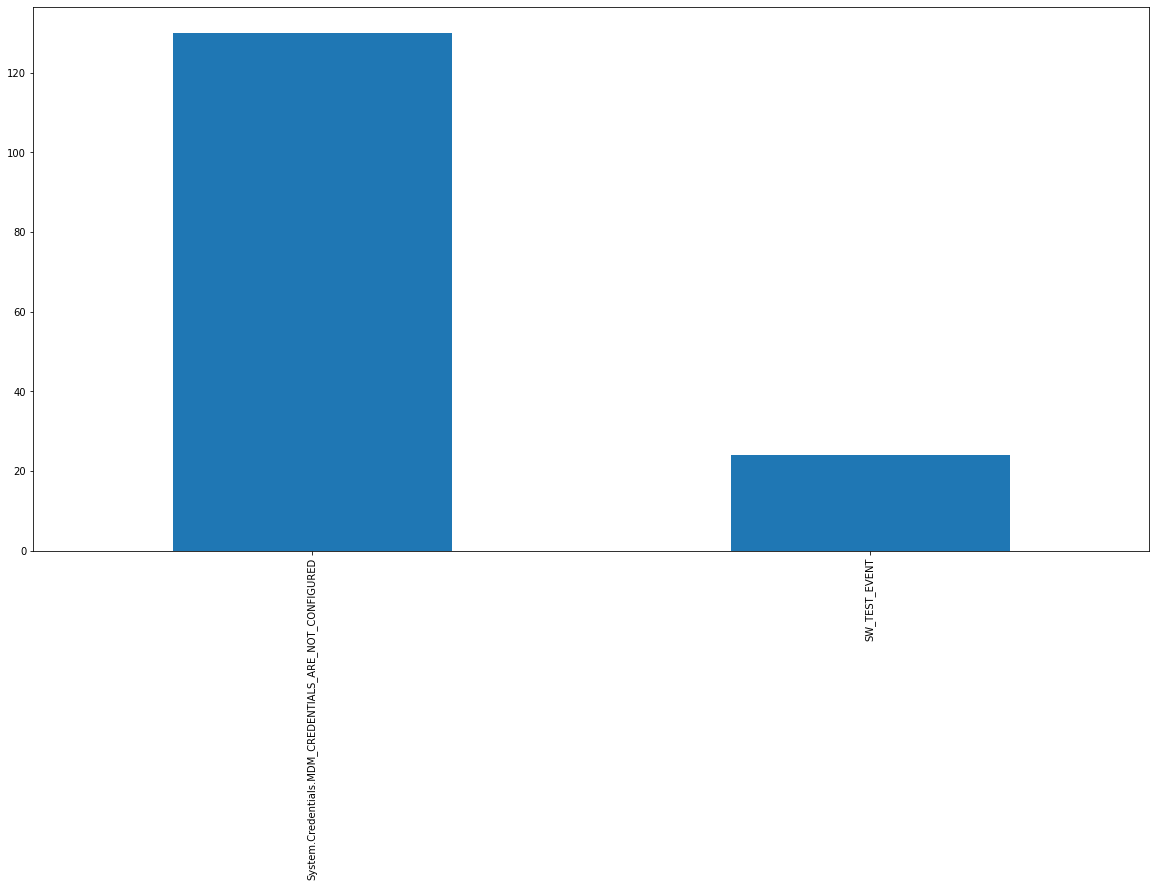

In [12]:
mess.plot(kind='bar', figsize=(20,10))

# Device Type for Past Two Hours

In [13]:
dev = df.deviceMibModule.value_counts()

<AxesSubplot:>

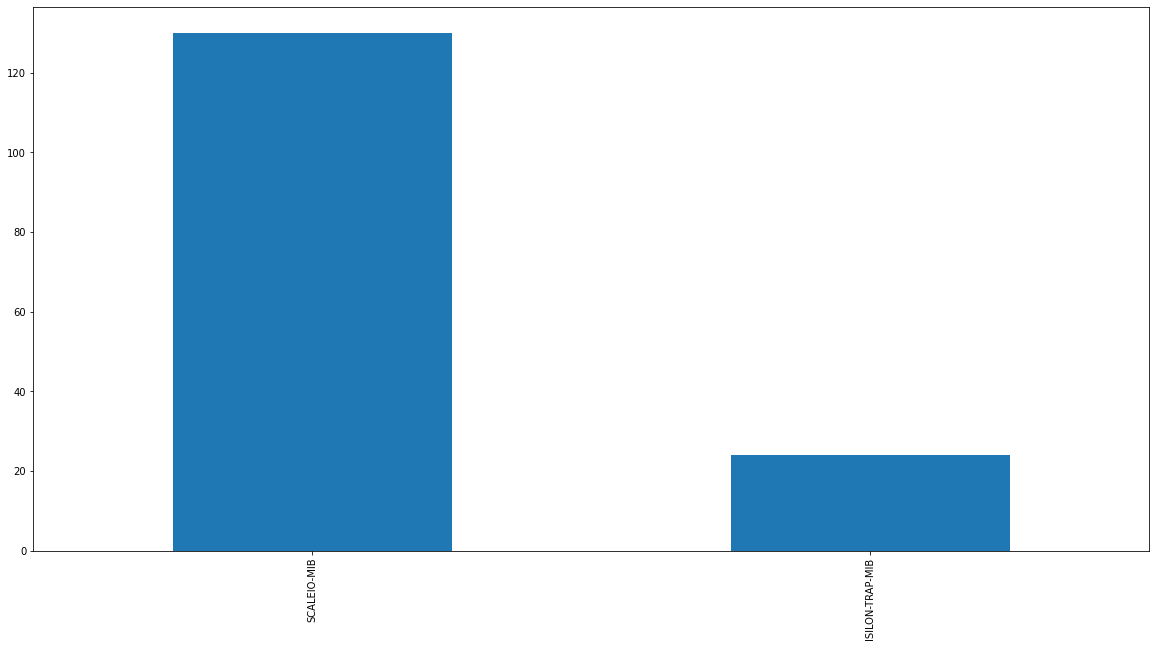

In [14]:
dev.plot(kind='bar', figsize=(20,10))

# SNMP Trap Type  Breakdown by Device for Past Two Hours

In [15]:
expand_df = pd.json_normalize(df['trap'], meta=['receivedTimestamp'])


In [16]:
df = df.join(expand_df).drop('trap', axis=1)

In [17]:
df[['deviceMibModule','type']].value_counts()

deviceMibModule  type  
SCALEIO-MIB      TRAP      130
ISILON-TRAP-MIB  INFORM     24
dtype: int64

# Counter Failure Message By Specific Name

In [18]:
failure_msg = 'SW_CELOG_HEARTBEAT'

In [19]:
len(df[df['notifyMessage']==failure_msg])

0